In [14]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# PySpark setup for reading and processing the CSV data
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [15]:
# Path to your CSV file (adjust accordingly)
file_path = 'C:\\Users\\MY-PC\\Downloads\\CSCE 5300 Final Project\\training.1600000.processed.noemoticon.csv'

# Load the data into a Spark DataFrame (assumes no header)
df_spark = spark.read.option("encoding", "ISO-8859-1").csv(file_path, header=False, inferSchema=True)

# Assign column names based on the dataset description
df_spark = df_spark.toDF("target", "ids", "date", "flag", "user", "text")

# Show the first few rows to check the data
df_spark.show(5)

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [16]:
# Convert Spark DataFrame to Pandas DataFrame for easier manipulation
df = df_spark.toPandas()

# Map sentiment labels to three categories (Negative = 0, Neutral = 2, Positive = 1)
df['label'] = df['target'].map({0: 0, 2: 2, 4: 1})  # 0 = Negative, 2 = Neutral, 1 = Positive

# Take only relevant columns
df = df[['text', 'label']]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Display some samples
df.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [17]:
# Set parameters for tokenizer and padding
max_vocab_size = 10000  # Maximum number of words to keep in the vocabulary
max_sequence_length = 100  # Maximum length of input sequences

# Initialize the tokenizer and fit on the training text
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)

# Convert the text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to make them the same length (max_sequence_length)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [18]:
# GloVe embedding settings
embedding_dim = 100
embedding_index = {}

# Load GloVe embeddings into a dictionary
glove_file_path = 'C:\\Users\\MY-PC\\Downloads\\CSCE 5300 Final Project\\glove.twitter.27B.100d.txt'  # Adjust this path
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

# Use tokenizer word index to populate the embedding matrix
for word, index in tokenizer.word_index.items():
    if index < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [19]:
# Build the CNN model
model = models.Sequential()

# Embedding layer using pre-trained GloVe embeddings
model.add(layers.Embedding(input_dim=max_vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_sequence_length, 
                           trainable=False))

# Convolutional layer with 128 filters and kernel size 5
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))

# Max pooling layer
model.add(layers.MaxPooling1D(pool_size=4))

# Global Max pooling layer
model.add(layers.GlobalMaxPooling1D())

# Dense layer
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer (softmax for multi-class classification)
model.add(layers.Dense(3, activation='softmax'))  # 3 classes: Negative, Neutral, Positive

# Compile the model with categorical crossentropy for multi-class classification
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Summary of the model architecture
model.summary()

C:\Users\MY-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [20]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 561s 14ms/step - accuracy: 0.7470 - loss: 0.5226 - val_accuracy: 0.7933 - val_loss: 0.4447
Epoch 2/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 601s 15ms/step - accuracy: 0.7876 - loss: 0.4634 - val_accuracy: 0.7966 - val_loss: 0.4383
Epoch 3/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 537s 13ms/step - accuracy: 0.7942 - loss: 0.4526 - val_accuracy: 0.7965 - val_loss: 0.4312
Epoch 4/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 506s 13ms/step - accuracy: 0.7984 - loss: 0.4444 - val_accuracy: 0.7988 - val_loss: 0.4268
Epoch 5/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 456s 11ms/step - accuracy: 0.8009 - loss: 0.4398 - val_accuracy: 0.8031 - val_loss: 0.4308
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.8026 - loss: 0.4305
Test Accuracy: 80.31%


In [21]:
# Example of new comments for prediction
new_comments = [
    "I love this product, it's amazing!",  # Positive
    "This is the worst thing I have ever purchased",  # Negative
    "It’s okay, not bad, not great"  # Neutral
]

# Convert new comments to sequences
new_seq = tokenizer.texts_to_sequences(new_comments)
new_pad = pad_sequences(new_seq, maxlen=max_sequence_length)

# Predict sentiment
predictions = model.predict(new_pad)
predictions = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

# Print predictions
for comment, pred in zip(new_comments, predictions):
    sentiment = "Positive" if pred == 1 else "Neutral" if pred == 2 else "Negative"
    print(f"Comment: {comment} | Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Comment: I love this product, it's amazing! | Sentiment: Positive
Comment: This is the worst thing I have ever purchased | Sentiment: Negative
Comment: It’s okay, not bad, not great | Sentiment: Negative


C:\Users\MY-PC\AppData\Local\Temp\ipykernel_8144\387078432.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


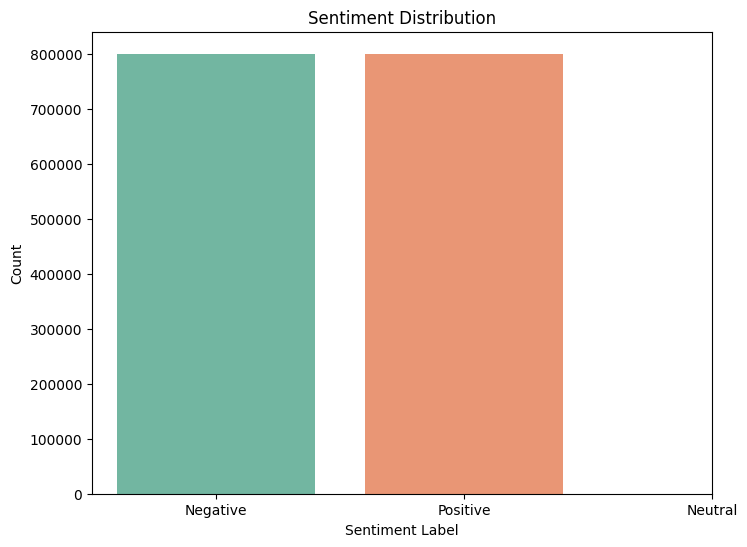

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of sentiment labels in the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Negative', 'Positive', 'Neutral'])
plt.show()

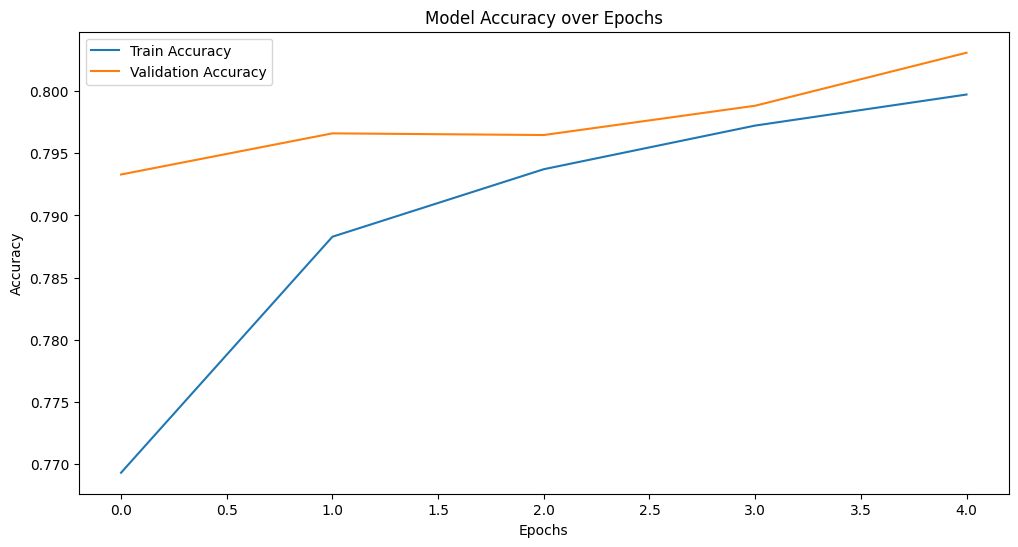

In [24]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

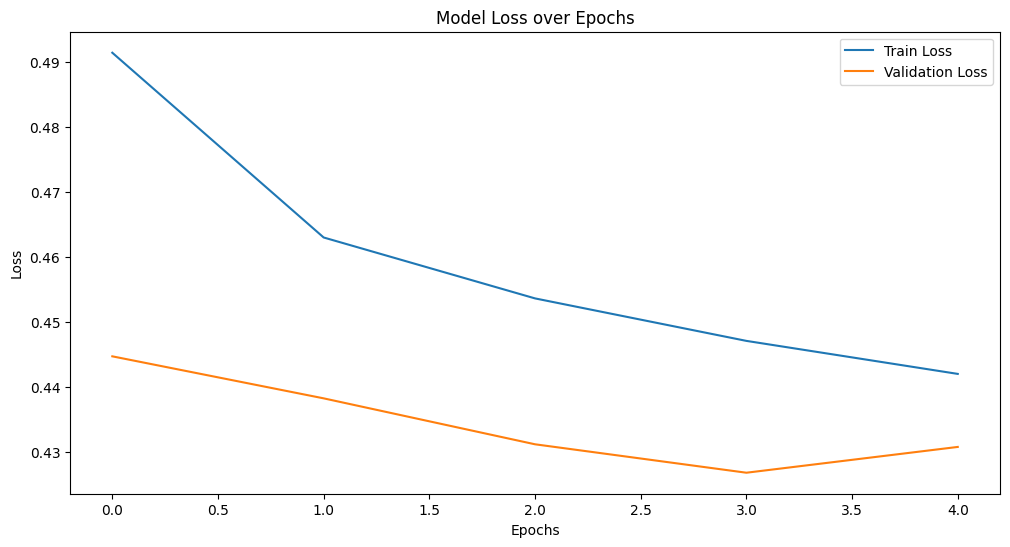

In [25]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step


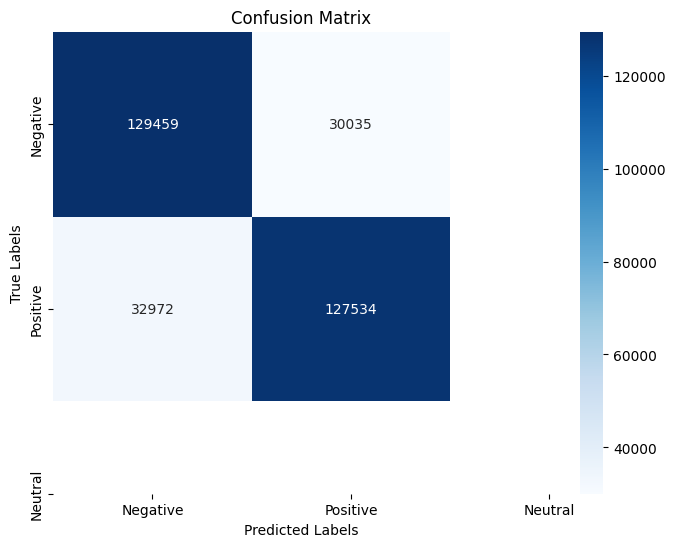

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Separate the data based on sentiment labels
negative_reviews = df[df['label'] == 0]['text'].values
positive_reviews = df[df['label'] == 1]['text'].values
neutral_reviews = df[df['label'] == 2]['text'].values

# Print the size of each sentiment category to help debug
print(f"Negative Reviews Count: {len(negative_reviews)}")
print(f"Positive Reviews Count: {len(positive_reviews)}")
print(f"Neutral Reviews Count: {len(neutral_reviews)}")

Negative Reviews Count: 800000
Positive Reviews Count: 800000
Neutral Reviews Count: 0


In [37]:
# Generate word clouds for each sentiment category
def generate_wordcloud(text, title):
    if len(text) == 0:
        print(f"Warning: No reviews found for {title}. Skipping word cloud.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    
    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Disable axis labels
    plt.title(title)
    
    # Ensure plot displays
    plt.show()

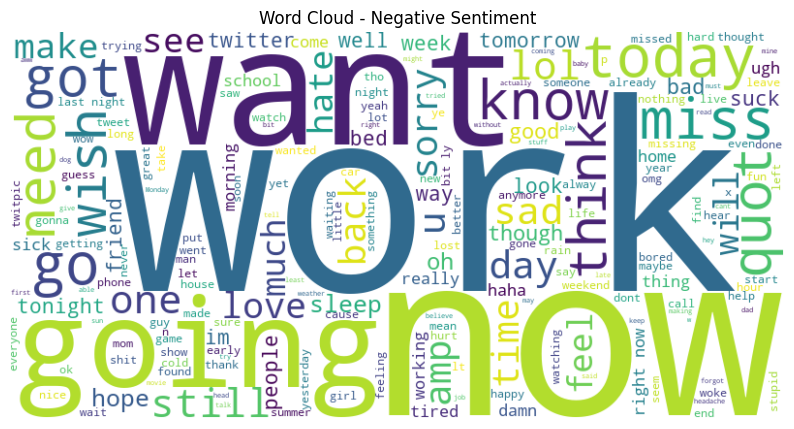

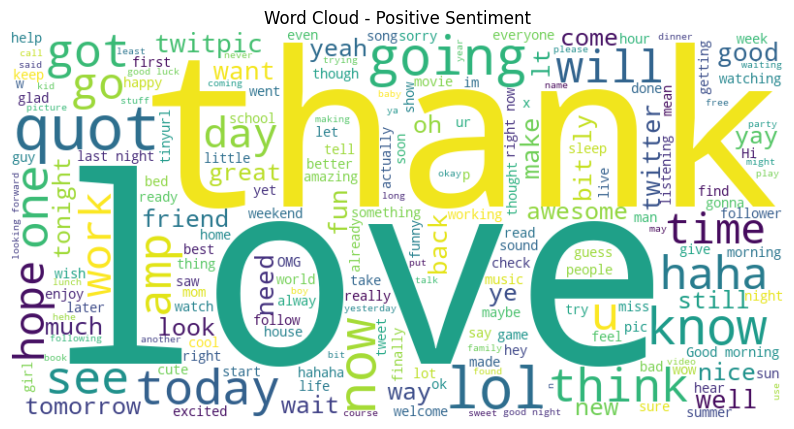

In [38]:
# Word clouds for each sentiment category
generate_wordcloud(negative_reviews, 'Word Cloud - Negative Sentiment')
generate_wordcloud(positive_reviews, 'Word Cloud - Positive Sentiment')
generate_wordcloud(neutral_reviews, 'Word Cloud - Neutral Sentiment')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


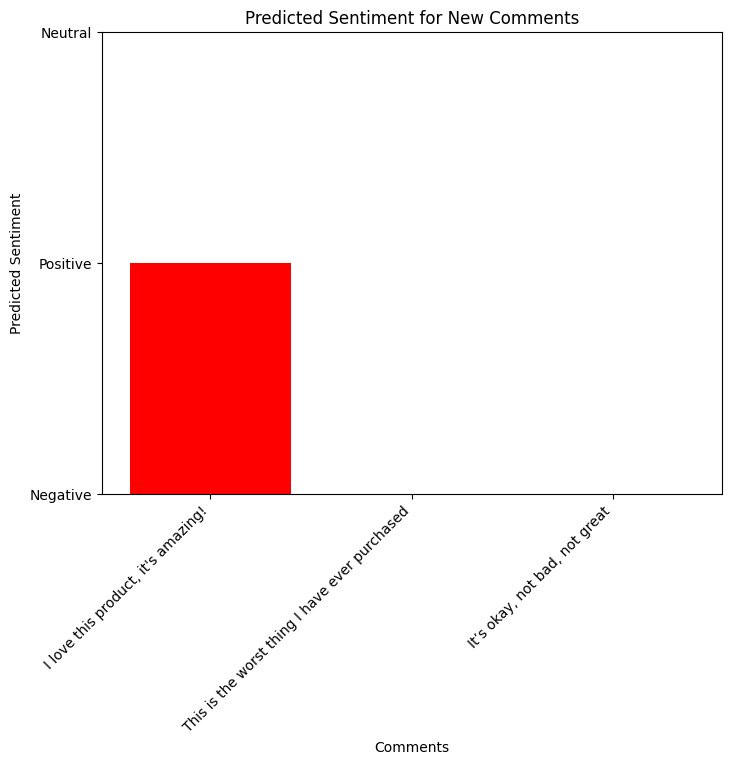

In [29]:
# Example of new comments for prediction
new_comments = [
    "I love this product, it's amazing!",  # Positive
    "This is the worst thing I have ever purchased",  # Negative
    "It’s okay, not bad, not great"  # Neutral
]

# Convert new comments to sequences
new_seq = tokenizer.texts_to_sequences(new_comments)
new_pad = pad_sequences(new_seq, maxlen=max_sequence_length)

# Predict sentiment
predictions = model.predict(new_pad)
predictions = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

# Visualize predictions
sentiment_labels = ['Negative', 'Positive', 'Neutral']
predicted_sentiments = [sentiment_labels[pred] for pred in predictions]

# Create a bar plot for the predictions
plt.figure(figsize=(8, 6))
plt.bar(new_comments, predictions, color=['red', 'green', 'blue'])
plt.xlabel('Comments')
plt.ylabel('Predicted Sentiment')
plt.title('Predicted Sentiment for New Comments')
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 1, 2], sentiment_labels)
plt.show()

In [30]:
# Print predictions
for comment, pred in zip(new_comments, predicted_sentiments):
    print(f"Comment: {comment} | Predicted Sentiment: {pred}")

Comment: I love this product, it's amazing! | Predicted Sentiment: Positive
Comment: This is the worst thing I have ever purchased | Predicted Sentiment: Negative
Comment: It’s okay, not bad, not great | Predicted Sentiment: Negative
